# Project McNulty Analysis

In this file I read the prepared data file (created in McNulty_DataRead.ipynb) and perform analysis on this data.

Several supervised learning techniques were used

* K Nearest Neighbor (KNN)
* Support Vector Machine (SVM)
* Logistic Regression
* Decision Tree
* Random Forest

In [5]:
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve,auc

from scipy import interp
from sklearn.metrics import make_scorer
from random import Random
import timeit

from IPython.display import Image

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import svm
import itertools
from sklearn.model_selection import StratifiedKFold


from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

from sklearn import tree

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

from datetime import datetime as dt
import datetime

import pickle

In [2]:
# read data file
FlightData1 = pd.read_csv('data/FlightData_2016_2017.csv')
FlightData2 = pd.read_csv('data/FlightData_2017_2018.csv')

In [3]:
FlightData1[(FlightData1.DEST == 'SEA') & (FlightData1.Delay == 1)].shape

(26767, 35)

In [3]:
def SetUp_Xy(FlightData):
    #print(FlightData.shape)
    # drop Alaska Airlines flights to shrink dataset
    #FlightData.drop(FlightData[FlightData.OP_UNIQUE_CARRIER == 'AS'].index,inplace=True)
    #print(FlightData.shape)
    
    # take a smaller sample of the data
    #FlightData = FlightData.sample(n=1000)

    SEA_outbound = False  # drop outbound flights if True
    SEA_inbound = True    # drop inbound flights if True
    if not SEA_inbound:
        print('dropping records arriving in SEA')
        FlightData.drop(FlightData[FlightData.DEST == 'SEA'].index,inplace=True)

    elif not SEA_outbound:
        print('dropping flights departing SEA')
        FlightData.drop(FlightData[FlightData.ORIGIN == 'SEA'].index,inplace=True)
    #print(FlightData.shape)

    # create one-hot columns for Airline Carrier
    X = pd.get_dummies(FlightData[['OP_UNIQUE_CARRIER']])
    
    # or don't use the Airline Carrier in the analysis
    #X = pd.DataFrame()
    
    # add datetime for FL_DATE (flight date)
    #X['FlightDate'] = pd.to_datetime(FlightData['FL_DATE'])
    #X['FlightDate'] = pd.to_datetime(FlightData['FL_DATE']).apply(lambda x: x.toordinal())
    #X['Day_of_year'] = (pd.to_datetime(FlightData['FL_DATE'])).dt.dayofyear

    # add other columns 
    #X = pd.concat([X, FlightData[['MONTH','DAY_OF_WEEK','Day_of_year','CRS_ARR_TIME',
    #                              'ARR_TIME','DISTANCE']]], axis=1, sort=False)
    X = pd.concat([X, FlightData[['MONTH','DAY_OF_WEEK','CRS_ARR_TIME',
                                  'CRS_FLIGHT_TIME','DISTANCE',
                                  'SEA_SNOW','SEA_TAVG','SEA_AWND',
                                  'ORD_SNOW','ORD_TAVG','ORD_AWND',
                                  'JFK_SNOW','JFK_TAVG','JFK_AWND'
                                ]]], axis=1, sort=False)
            
    # set up target
    y = FlightData['Delay']

    return X,y

In [4]:
X1,y1 = SetUp_Xy(FlightData1)
X2,y2 = SetUp_Xy(FlightData2)

dropping flights departing SEA
dropping flights departing SEA


In [6]:
print(X2.shape, y2.shape)

(166491, 26) (166491,)


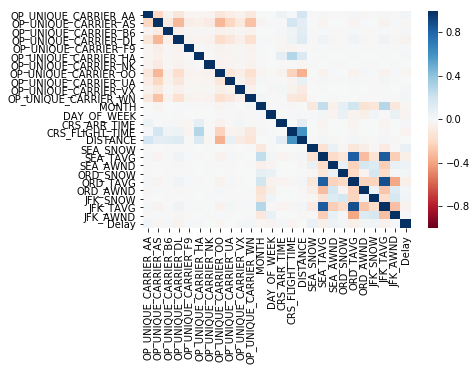

In [7]:
import seaborn as sns
corr = pd.concat([X1,y1],axis=1).corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, vmin=-1, vmax=1, cmap='RdBu')

In [9]:
print(corr['Delay'])

OP_UNIQUE_CARRIER_AA    0.033595
OP_UNIQUE_CARRIER_AS   -0.015559
OP_UNIQUE_CARRIER_B6    0.019004
OP_UNIQUE_CARRIER_DL   -0.037803
OP_UNIQUE_CARRIER_F9    0.014733
OP_UNIQUE_CARRIER_HA    0.017632
OP_UNIQUE_CARRIER_NK    0.007649
OP_UNIQUE_CARRIER_OO   -0.015674
OP_UNIQUE_CARRIER_UA    0.002516
OP_UNIQUE_CARRIER_VX    0.019244
OP_UNIQUE_CARRIER_WN    0.030132
MONTH                  -0.019423
DAY_OF_WEEK            -0.029959
CRS_ARR_TIME            0.020027
CRS_FLIGHT_TIME        -0.023454
DISTANCE                0.002204
SEA_SNOW                0.064678
SEA_TAVG               -0.061881
SEA_AWND                0.054901
ORD_SNOW                0.031208
ORD_TAVG               -0.057510
ORD_AWND                0.028246
JFK_SNOW                0.034184
JFK_TAVG               -0.042304
JFK_AWND                0.012134
Delay                   1.000000
Name: Delay, dtype: float64


In [10]:
corr.columns

Index(['OP_UNIQUE_CARRIER_AA', 'OP_UNIQUE_CARRIER_AS', 'OP_UNIQUE_CARRIER_B6',
       'OP_UNIQUE_CARRIER_DL', 'OP_UNIQUE_CARRIER_F9', 'OP_UNIQUE_CARRIER_HA',
       'OP_UNIQUE_CARRIER_NK', 'OP_UNIQUE_CARRIER_OO', 'OP_UNIQUE_CARRIER_UA',
       'OP_UNIQUE_CARRIER_VX', 'OP_UNIQUE_CARRIER_WN', 'MONTH', 'DAY_OF_WEEK',
       'CRS_ARR_TIME', 'CRS_FLIGHT_TIME', 'DISTANCE', 'SEA_SNOW', 'SEA_TAVG',
       'SEA_AWND', 'ORD_SNOW', 'ORD_TAVG', 'ORD_AWND', 'JFK_SNOW', 'JFK_TAVG',
       'JFK_AWND', 'Delay'],
      dtype='object')

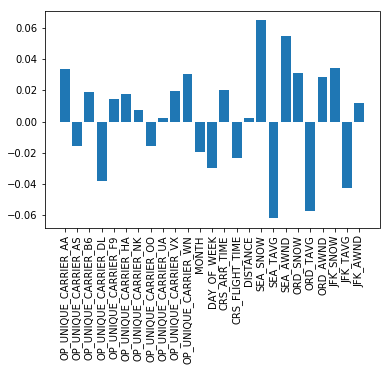

In [11]:
Delay_corr = corr['Delay']
Delay_corr.drop(labels=['Delay'],inplace=True)
plt.bar(Delay_corr.index,Delay_corr);
plt.xticks(rotation=90);


In [ ]:
X1.describe()

In [ ]:
X2.columns

In [6]:
# add G4 airline if not in database
if 'OP_UNIQUE_CARRIER_G4' not in X1.columns:
    print('adding OP_UNIQUE_CARRIER_G4 column')
    X1['OP_UNIQUE_CARRIER_G4'] = 0
    # re-order the columns to match X2
    X1 = X1[X2.columns]

adding OP_UNIQUE_CARRIER_G4 column


### Train Test Split

In [7]:
# STEP 1: split X and y into training and testing sets
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.4, 
                                                        random_state=42, stratify = y2.values)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.4, 
                                                        random_state=42, stratify = y1.values)

print('X1')
print('balance in base set:     ',y1[y1 == 0].count(), y1[y1 == 1].count())

print(X1_train.shape,y1_train.shape)
print(X1_test.shape,y1_test.shape)
print('balance in training set: ',y1_train[y1_train == 0].count(), y1_train[y1_train == 1].count())
print('balance in test set:     ',y1_test[y1_test == 0].count(),   y1_test[y1_test == 1].count())

print(' ')
print('X2')
print('balance in base set:     ',y2[y2 == 0].count(), y2[y2 == 1].count())

print(X2_train.shape,y2_train.shape)
print(X2_test.shape,y2_test.shape)
print('balance in training set: ',y2_train[y2_train == 0].count(), y2_train[y2_train == 1].count())
print('balance in test set:     ',y2_test[y2_test == 0].count(),   y2_test[y2_test == 1].count())

X1
balance in base set:      124317 29834
(92490, 26) (92490,)
(61661, 26) (61661,)
balance in training set:  74590 17900
balance in test set:      49727 11934
 
X2
balance in base set:      136589 29902
(99894, 26) (99894,)
(66597, 26) (66597,)
balance in training set:  81953 17941
balance in test set:      54636 11961


In [8]:
# create a dataset combining X2 and X1
X3_train = pd.concat([X2_train,X1_train])
y3_train = pd.concat([y2_train,y1_train])

# reduce training set
#X3_train = X3_train.sample(frac=0.25, random_state=1)
#y3_train = y3_train.sample(frac=0.25, random_state=1)

In [9]:
X_train = X3_train.copy()
y_train = y3_train.copy()

DownSample = True
if DownSample:
    # remove enough rows where Delay=0 to make classes even
    df2_D1 = X_train[y_train == 1]

    df2_D0 = X_train[y_train == 0]
    df2_D0 = df2_D0.sample(n=df2_D1.shape[0], random_state=1)  # even Delay=1 & 0
    X_train = pd.concat([df2_D1,df2_D0])

    y_D1 = y_train[y_train == 1]
    y_D0 = y_train[y_train == 0]
    y_D0 = y_D0.sample(n=df2_D1.shape[0], random_state=1)
    y_train = pd.concat([y_D1,y_D0])
 

X_test = X1_test.sample(frac=1.0, random_state=1).copy()
y_test = y1_test.sample(frac=1.0, random_state=1).copy()

X2_test = X2_test.sample(frac=1.0, random_state=1).copy()
y2_test = y2_test.sample(frac=1.0, random_state=1).copy()

# normalize the data
ssX = StandardScaler()
X_train = pd.DataFrame(ssX.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
#X_test_scaled = ssX.transform(X_test)
X_test = pd.DataFrame(ssX.fit_transform(X_test), index=X_test.index, columns=X_test.columns)
X2_test = pd.DataFrame(ssX.fit_transform(X2_test), index=X2_test.index, columns=X2_test.columns)


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with i

In [10]:
X_test = X1_test.copy()
y_test = y1_test.copy()
X_test = pd.DataFrame(ssX.fit_transform(X_test), index=X_test.index, columns=X_test.columns)

X2_test = X2_test.copy()
y2_test = y2_test.copy()
X2_test = pd.DataFrame(ssX.fit_transform(X2_test), index=X2_test.index, columns=X2_test.columns)


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


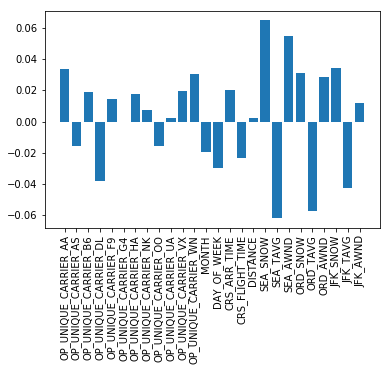

In [16]:
corr = pd.concat([X1,y1],axis=1).corr()
Delay_corr = corr['Delay']
Delay_corr.drop(labels=['Delay'],inplace=True)
plt.bar(Delay_corr.index,Delay_corr);
plt.xticks(rotation=90);


In [17]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)
print('balance in training set: ',y_train[y_train == 0].count(), y_train[y_train == 1].count())
print('balance in test set:     ',y_test[y_test == 0].count(),   y_test[y_test == 1].count())
print('balance in test2 set:    ',y2_test[y2_test == 0].count(), y2_test[y2_test == 1].count())

(71682, 26) (71682,)
(61661, 26) (61661,)
balance in training set:  35841 35841
balance in test set:      49727 11934
balance in test2 set:     54636 11961


## KNN

In [18]:
model_knn = KNeighborsClassifier(n_neighbors=10, n_jobs=-1)
model_knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=10, p=2,
           weights='uniform')

In [19]:
print(X_train.shape, y_train.shape)

(71682, 26) (71682,)


In [20]:
model_knn.predict(X_test)

array([1, 0, 0, ..., 0, 0, 0])

              precision    recall  f1-score   support

           0       0.86      0.65      0.74     49727
           1       0.28      0.56      0.37     11934

   micro avg       0.64      0.64      0.64     61661
   macro avg       0.57      0.61      0.56     61661
weighted avg       0.75      0.64      0.67     61661

Accuracy Score:  0.635036733105
 
Confusion matrix, without normalization
[[32496 17231]
 [ 5273  6661]]


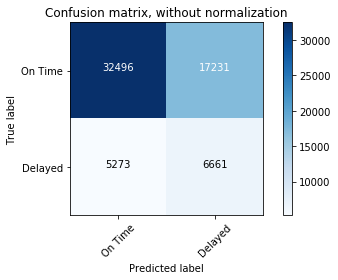

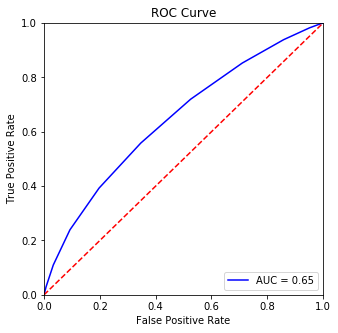

In [26]:
y_pred       = model_knn.predict(X_test)
y_pred_proba = model_knn.predict_proba(X_test)[:,1]
results_analysis(y_test,y_pred,y_pred_proba)

              precision    recall  f1-score   support

           0       0.87      0.69      0.77     54636
           1       0.27      0.53      0.36     11961

   micro avg       0.66      0.66      0.66     66597
   macro avg       0.57      0.61      0.56     66597
weighted avg       0.76      0.66      0.69     66597

Accuracy Score:  0.65746204784
 
Confusion matrix, without normalization
[[37471 17165]
 [ 5647  6314]]


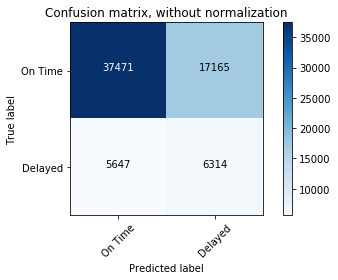

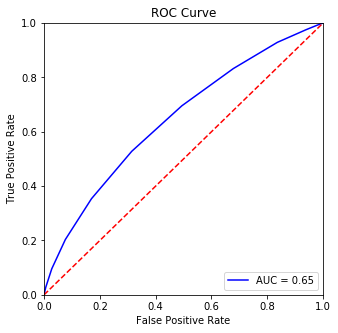

In [27]:
y2_pred       = model_knn.predict(X2_test)
y2_pred_proba = model_knn.predict_proba(X2_test)[:,1]
results_analysis(y2_test,y2_pred,y2_pred_proba)

In [28]:
# search for an optimal value of K for KNN
k_range = list(range(1, 31))

k_scores = []
for k in k_range:
    model_knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(model_knn, X_train, y_train, cv=10, scoring='accuracy',n_jobs=-1)
    k_scores.append(scores.mean())
print(k_scores)

# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

KeyboardInterrupt: 

In [ ]:
#Randomized Search to find best number of neighbors
model_knn = KNeighborsClassifier(n_jobs=-1)


k_range = list(range(1, 100))
weight_options = ['uniform', 'distance']

param_dist = dict(n_neighbors=k_range, weights=weight_options)

# n_iter controls the number of searches
rand = RandomizedSearchCV(model_knn, param_dist, cv=10, 
                          scoring='accuracy', n_iter=10, random_state=42, n_jobs=-1)
rand.fit(X_train, y_train)
rand.cv_results_['params']

## SVM

In [ ]:
#model_svm = svm.SVC(kernel='linear')
model_svm = svm.SVC(kernel='linear', C=1)


In [ ]:
t1 = pd.Timestamp.now()
model_svm.fit(X_train, y_train)
y_pred = model_svm.predict(X_test)
accuracy_score(y_test,y_pred)
print('time = ',pd.Timestamp.now()-t1)

In [ ]:
y_pred_proba = model_svm.predict_proba(X_test)[:,1]
results_analysis(y_test,y_pred,y_pred_proba)

In [ ]:
#param_grid = [
#  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
#  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
# ]

param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
 ]

In [ ]:
grid = GridSearchCV(svm.SVC(), param_grid)
grid.fit(X_train, y_train)

## Logistic Regression

In [29]:
model_logreg = LogisticRegression(C= 1, penalty = 'l2')
model_logreg.fit(X=X_train, y=y_train)
print(model_logreg.score(X=X_test, y=y_test))
y_pred = model_logreg.predict(X_test)


0.556964694053


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.84      0.56      0.67     49727
           1       0.23      0.56      0.33     11934

   micro avg       0.56      0.56      0.56     61661
   macro avg       0.54      0.56      0.50     61661
weighted avg       0.72      0.56      0.60     61661

Accuracy Score:  0.556964694053
 
Confusion matrix, without normalization
[[27651 22076]
 [ 5242  6692]]


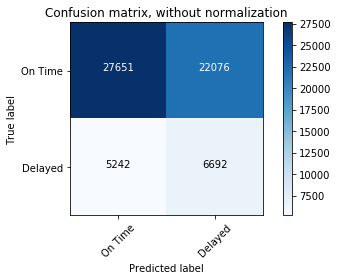

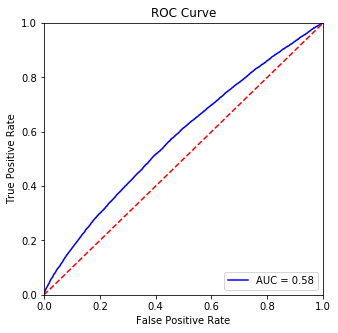

In [30]:
y_pred_proba = model_logreg.predict_proba(X_test)[:,1]
results_analysis(y_test,y_pred,y_pred_proba)

In [31]:
param_grid = {'C': np.logspace(-3,6, 13),'penalty': ['l1', 'l2']}
#param_grid = {'C': np.logspace(-3,6, 12)}

In [ ]:
np.logspace(-3,6,13)

In [ ]:
param_grid = {'C': np.logspace(-3,6, 13),'penalty': ['l1', 'l2']}
grid = GridSearchCV(LogisticRegression(), param_grid,n_jobs=-1)
grid.fit(X_train, y_train)
print(f"best score: {grid.best_score_}")
print(f"best params: {grid.best_params_}")

## Decision Tree

In [32]:
model_dt = tree.DecisionTreeClassifier(max_depth = 14,min_samples_leaf=6)
model_dt.fit(X=X_train, y=y_train)
model_dt.feature_importances_

array([ 0.  ,  0.03,  0.  ,  0.02,  0.  ,  0.  ,  0.  ,  0.  ,  0.01,
        0.  ,  0.  ,  0.01,  0.05,  0.04,  0.25,  0.13,  0.09,  0.01,
        0.09,  0.06,  0.01,  0.05,  0.05,  0.  ,  0.06,  0.04])

In [33]:
y_pred = model_dt.predict(X_test)

              precision    recall  f1-score   support

           0       0.85      0.57      0.69     49727
           1       0.25      0.59      0.35     11934

   micro avg       0.58      0.58      0.58     61661
   macro avg       0.55      0.58      0.52     61661
weighted avg       0.74      0.58      0.62     61661

Accuracy Score:  0.577496310472
 
Confusion matrix, without normalization
[[28570 21157]
 [ 4895  7039]]


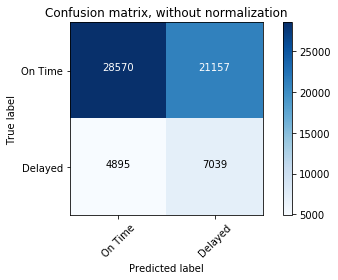

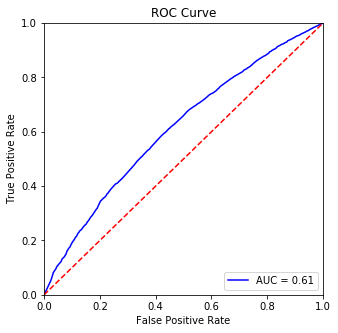

In [34]:
y_pred_proba = model_dt.predict_proba(X_test)[:,1]
results_analysis(y_test,y_pred,y_pred_proba)

In [ ]:
param_grid = {'max_depth': [1,2,4,6,8,10,12,13,14,15,16,17],'min_samples_leaf': [3,5,6,7,8,10]}

grid = GridSearchCV(tree.DecisionTreeClassifier(), param_grid,n_jobs=-1)
grid.fit(X_train, y_train)
print(f"best score: {grid.best_score_}")
print(f"best params: {grid.best_params_}")

## Random Forest

In [11]:
model_rf = RandomForestClassifier(n_estimators=350, max_depth=20,min_samples_leaf=4,random_state=0)
#model_rf = RandomForestClassifier(n_estimators=100, max_depth=10,min_samples_leaf=4,random_state=0)

model_rf.fit(X=X_train, y=y_train)
print(model_rf.feature_importances_)
model_rf.score(X=X_test, y=y_test)

[ 0.00638847  0.01462267  0.00195885  0.01150548  0.00094937  0.00081725
  0.00116997  0.00089388  0.00793715  0.0051492   0.00168167  0.00912267
  0.04430913  0.04132974  0.18492074  0.13254072  0.10520416  0.00703016
  0.07477945  0.07066445  0.00727478  0.06419472  0.06812982  0.00424149
  0.06532881  0.06785518]


0.65007054702323996

In [18]:
pickle.dump(model_rf, open('Seatac_model.pkl', 'wb'))

              precision    recall  f1-score   support

           0       0.88      0.65      0.75     49727
           1       0.31      0.64      0.41     11934

   micro avg       0.65      0.65      0.65     61661
   macro avg       0.59      0.64      0.58     61661
weighted avg       0.77      0.65      0.69     61661

Accuracy Score:  0.650070547023
 
Confusion matrix, without normalization
[[32497 17230]
 [ 4347  7587]]


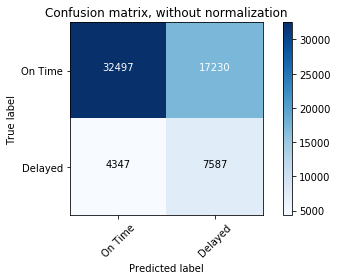

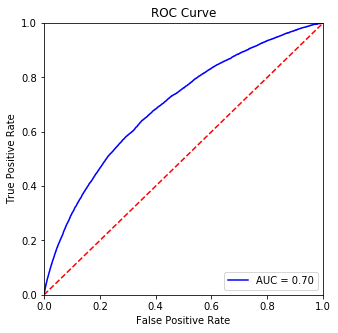

In [17]:
y_pred       = model_rf.predict(X_test)
y_pred_proba = model_rf.predict_proba(X_test)[:,1]
results_analysis(y_test,y_pred,y_pred_proba)

#ROC_plot(y_test,y_pred_proba)

In [ ]:
y2_pred = model_rf.predict(X2_test)
y2_pred_proba = model_rf.predict_proba(X_test)[:,1]
results_analysis(y2_test,y2_pred,y2_pred_proba)

In [ ]:
#param_grid = {'n_estimators': [100,200,300,350,400,450,500],'max_depth': [1,5,10,14,18,20,22,24,26],'min_samples_leaf': [1,2,3,4,5,6,10]}
param_grid = {'n_estimators': [100,200,300,350],'max_depth': [1,5,10,14,18,20],'min_samples_leaf': [3,4,5,6,10]}

grid = GridSearchCV(RandomForestClassifier(), param_grid,n_jobs=-1)
grid.fit(X_train, y_train)
print(f"best score: {grid.best_score_}")
print(f"best params: {grid.best_params_}")


In [ ]:
print(results.keys())

In [ ]:
print(results['mean_test_score'])

In [ ]:
results = grid.cv_results_

plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
          fontsize=16)

plt.ylabel("Score")

ax = plt.gca()
#ax.set_xlim(0, 402)
#ax.set_ylim(0.73, 1)

# Get the regular numpy array from the MaskedArray
#plt.xlabel("min_samples_split")
#X_axis = np.array(results['param_min_samples_leaf'].data, dtype=float)
plt.xlabel("")n_estimators
X_axis = np.array(results['param_n_estimators'].data, dtype=float)

#scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}
scoring = {'score': 'param_n_estimators','score': make_scorer(accuracy_score)}

for scorer, color in zip(sorted(scoring), ['g', 'k']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        #sample_score_std = results['std_%s_%s' % (sample, scorer)]
        #ax.fill_between(X_axis, sample_score_mean - sample_score_std,
        #                sample_score_mean + sample_score_std,
        #                alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid('off')
plt.show()

In [ ]:
# Cross Validation
splits = 5
KFold_ROC_RandForest(X_train,y_train,splits)

In [ ]:
X_train.shape
#X_test.shape

## Monkey Model (assume predict all on-time)

In [ ]:
# create training target assuming always on-time
y_pred = np.zeros(shape=y_test.shape, dtype='int')

In [ ]:
y_pred_proba = np.zeros(shape=y_test.shape)
results_analysis(y_test,y_pred,y_pred_proba)

### Confusion Matrix

In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


### Plot ROC Curve   
Receiver Operating Characteristic curve

In [14]:
def ROC_plot(y_test,y_pred_proba):
    fpr,tpr,cuts = roc_curve(y_test,y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, 'b', label = f'AUC = {roc_auc:0.2f}')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC Curve')
    plt.show()

In [15]:
def results_analysis(y_test,y_pred,y_pred_proba):
    print(classification_report(y_test, y_pred))
    
    print('Accuracy Score: ',accuracy_score(y_test,y_pred))
    
    # Compute confusion matrix
    print(' ')
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=('On Time','Delayed'),
                          title='Confusion matrix, without normalization')

    ROC_plot(y_test,y_pred_proba)

In [16]:
def KFold_ROC_RandForest(X,y,splits):
    # Run classifier with cross-validation and plot ROC curves
    cv = StratifiedKFold(n_splits=splits)
    classifier = RandomForestClassifier(n_estimators=350, max_depth=20,min_samples_leaf=4,random_state=0)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    for train, test in cv.split(X, y):
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y.iloc[train], y.iloc[test]

        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_test,y_pred)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()